# HACKTHON 4

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings


from tqdm import tqdm
from collections import Counter
from spacy.matcher import Matcher
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from nltk.tokenize import WordPunctTokenizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

import os
import re
import nltk
import spacy

cpu_count = int(os.cpu_count()) if os.cpu_count() != None else 4

In [2]:
%matplotlib inline
warnings.simplefilter("ignore")

## 1 - Import Dataset

In [3]:
df = pd.read_csv('./data/book_review_labelled_data.csv')
df.drop(["overall"], axis=1,inplace=True)
#df.rename(columns={"v1":"label", "v2":"message"},inplace=True)
df.head()

,reviewerID,reviewerName,reviewText,summary,reviewTime,rates_count,helpful_count,rating
0,A3UPFTGAWZ3G2R,David J. Loftus,"Jenkins, a history professor and Member of Par...","Quite readable, nicely done","12 6, 2001",40,37,4
1,A1XTKTLNSCRLDS,Ellen Rappaport,Detective Inspector Erlendur Sveinsson is at h...,Mesmerizing in depth,"02 23, 2014",0,0,5
2,A1A77B6DQQH436,"crescamp ""esc""",I didn't read this. I purchased it for a gift...,10-minute life lessons for kids,"02 12, 2013",3,0,3
3,AEAF4MRYHJZI,"Angelia Menchan ""acvermen.blogspot.com""",Fierce Angels by Sheri Park reads like a disse...,So FIERCE,"03 24, 2010",9,9,4
4,A3B7KU72LGWFER,"Grifel ""Tea Time""",Clearly this author had two goals in mind: 1) ...,Drivel!,"06 21, 2003",19,13,1


In [4]:
# have the same values for all lines
#df[df['overall'] != df['rating']]

In [5]:
df_test = pd.read_csv('./data/book_review_test_data_unlabelled.csv')
df_test.head()


,reviewerID,reviewerName,reviewText,summary,reviewTime,rating
0,A2HESNQJZ9OB7H,Jen,So boring and stupid had a hard time finishing...,Unbelievable.,"02 16, 2014",1
1,A1ABXPSFA9PC8N,Ben Parker,Ill be the first to admit i'm not the best coo...,Easy and Clear Cooking,"11 7, 2012",5
2,AYVW3O6W8S5S4,Johnny in Texas,Doesn't tell you how to do anything... just s...,not bad,"02 25, 2014",3
3,A17GOTFSUAWN17,Tyson,Whenever I met my last two girlfriends in pers...,"Short book, but good primer on how to text girls","03 15, 2014",4
4,A2VO8K861AV83R,"Avatheps ""Avatheps""",I read the reviews and decided to take a chanc...,Very disappointing. I could not finish it.,"12 30, 2013",2


## 1.0 - Label the data

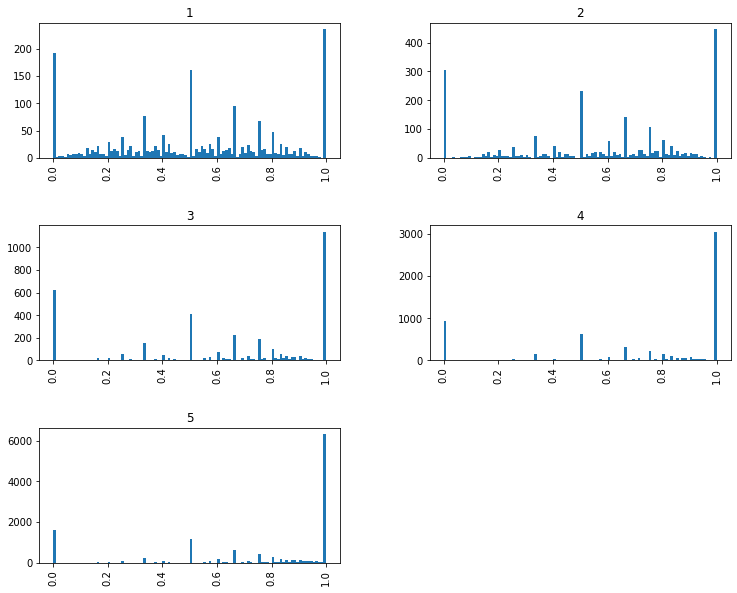

In [6]:
df['label_aux'] = df['helpful_count']/df['rates_count']
df.hist(column='label_aux', by ='rating', bins=100,figsize=(12,10));

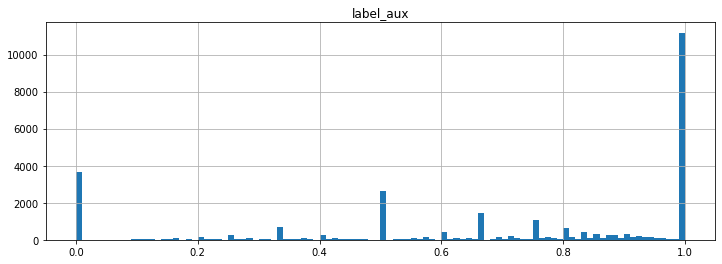

In [7]:
df.hist(column='label_aux', bins=100,figsize=(12,4));

In [8]:
#df.drop(["label_aux"], axis=1,inplace=True)
threshold = 0.8
df['label'] = (df['label_aux'] >= threshold)
df['label'].value_counts(normalize=True)

False    0.705093
True     0.294907
Name: label, dtype: float64

In [9]:
df.shape

(49992, 10)

In [10]:
df['rates_count'].value_counts()

0      21569
1       8230
2       4582
3       2867
4       2172
       ...  
268        1
204        1
140        1
267        1
639        1
Name: rates_count, Length: 243, dtype: int64

### Text to train

In [11]:
df_train = df[df['rates_count']>0]

### Pre-process

In [12]:
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe("merge_entities", after="ner")
en_stopwords = nlp.Defaults.stop_words

In [13]:
tokenizer = WordPunctTokenizer()

def remove_punctuation(text):
    """
    Hint: Remember the good old RegEx from 2 LUs ago
        how can I just remove everything except words, digits and spaces?
    """
    text = re.sub(r'[^A-Za-z0-9\s]','',text)
    return text.lower()

def remove_stopwords(text, stopwords):
    """
    Hint: You may want to split the text into tokens using the tokenizer, it might help when searching for stopwords
        If you do, do not forget to join the tokens afterwards!
    """
    words = tokenizer.tokenize(text)
    words = [word for word in words if word not in stopwords]
    text_processed = ' '.join(words)
    
    # Return the full string again here
    return text_processed

def preprocess_text(df):
    
    df_processed = df.copy()
    
    df_processed["reviewText"] = df_processed["reviewText"].apply(remove_punctuation)
    df_processed["reviewText"] = df_processed["reviewText"].apply(remove_stopwords, stopwords = en_stopwords)
    
    return df_processed

In [14]:
df_train_processed = preprocess_text(df_train)
df_test_processed = preprocess_text(df_test)

## 1.1 - Baseline - TFidVectorizer

In [15]:
# Target class distribution
df_train_processed['label'].value_counts(normalize=True)

True     0.5187
False    0.4813
Name: label, dtype: float64

In [16]:
def baseline_with_tfidf(X_train, X_val, y_train, y_val, X_test):
    """
    Train a Random Forest using sklearn's Pipeline and return the trained model and its accuracy in the test set.
    """
    
    pipe = Pipeline([
                   ('tfidf', TfidfVectorizer()),
                   ('clf', MultinomialNB())])

    pipe.fit(X_train, y_train)
    y_val_pred = pipe.predict(X_val)
    score_val = f1_score(y_val, y_val_pred)
    y_test_pred = pipe.predict(X_test)
    
    return pipe, score_val, y_test_pred

In [17]:
X_train, X_val, y_train, y_val = train_test_split(df_train_processed["reviewText"], df_train_processed["label"], 
                                                    test_size=0.2, random_state=42)
baseline_model, baseline_score, baseline_prediction = baseline_with_tfidf(X_train, X_val, y_train, y_val, df_test_processed['reviewText'])

baseline_score

0.6782717595491548

In [19]:
def create_output(labels):
    df = pd.DataFrame({'is_helpful':labels})
    df['is_helpful'] = df['is_helpful'].apply(lambda x: 'true' if x==True else 'false')
    df.to_csv('./data/submission.csv', index=False)

In [20]:
create_output(baseline_prediction)

## 1.2 - Vector Words - Spacy (work the sentence using mean, sum, .... in this case the mean) 

In [7]:
# Split in train and validation
train_data, test_data = train_test_split(df, test_size=0.2, random_state=41)

In [8]:
nlp = spacy.load('en_core_web_md')
def sentvec_tfidf(s, stopwords):
    sent = nlp(s)
    return np.average(np.array([w.vector for w in sent if w.text not in stopwords]), axis=0)
    
def build_sentence_vecs_tfidf(docs, stopwords):
    num_examples = len(docs)
    word_vector_shape = nlp.vocab.vectors.shape[-1]
    vectors = np.zeros([num_examples, word_vector_shape])
    for ii, doc in enumerate(docs):
        vector = sentvec_tfidf(doc, stopwords)
        vectors[ii] = vector
    
    # in case we get any NaN's or Inf, replace them with 0s
    return np.nan_to_num(vectors)

In [9]:
# Run with english stopwords
stopwords = set(nltk.corpus.stopwords.words('english'))
X_train = build_sentence_vecs_tfidf(train_data['message'].values, stopwords)
X_test = build_sentence_vecs_tfidf(test_data['message'].values, stopwords)   

clf =  KNeighborsClassifier()
clf.fit(X_train, train_data['label'])
pred = clf.predict(X_test)
print('Accuracy: {}'.format(accuracy_score(pred, test_data['label'])))

Accuracy: 0.9524663677130045


## 1.3 - Adding extra features

In [10]:
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe("merge_entities", after="ner")
en_stopwords = nlp.Defaults.stop_words

#### Pre-processed

In [11]:
tokenizer = WordPunctTokenizer()

def remove_punctuation(text):
    """
    Hint: Remember the good old RegEx from 2 LUs ago
        how can I just remove everything except words, digits and spaces?
    """
    text = re.sub(r'[^A-Za-z0-9\s]','',text)
    return text.lower()

def remove_stopwords(text, stopwords):
    """
    Hint: You may want to split the text into tokens using the tokenizer, it might help when searching for stopwords
        If you do, do not forget to join the tokens afterwards!
    """
    words = tokenizer.tokenize(text)
    words = [word for word in words if word not in stopwords]
    text_processed = ' '.join(words)
    
    # Return the full string again here
    return text_processed

def preprocess_text(df):
    
    df_processed = df.copy()
    
    df_processed["message"] = df_processed["message"].apply(remove_punctuation)
    df_processed["message"] = df_processed["message"].apply(remove_stopwords, stopwords = en_stopwords)
    
    return df_processed

In [12]:
df_processed = preprocess_text(df)
df_processed.head()

,label,message
0,ham,jurong point crazy available bugis n great wor...
1,ham,ok lar joking wif u oni
2,spam,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,u dun early hor u c
4,ham,nah dont think goes usf lives


#### POS-Tagging Search

In [13]:
# Let's get the text of the news article processed by SpaCy - This might take a while depending on 
#   your hardware (a break to walk the dog? 🐶)
docs = list(tqdm(nlp.pipe(df["message"], batch_size=20, n_process=cpu_count-1), total=len(df["message"])))
docs[:3]

100%|██████████| 5572/5572 [00:22<00:00, 242.35it/s]


[Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...,
 Ok lar... Joking wif u oni...,
 Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's]

In [24]:
## Add adjectives and adverbs count
matcher = Matcher(nlp.vocab)
pattern = [[{'POS': 'ADJ'}], [{'POS': 'ADV'}]]
matcher.add('LOC', pattern)


nb_adj_adv = []
for i, doc in enumerate(docs):
    matches = matcher(doc)
    count = 0
    for match_id, start, end in matches:
        span = doc[start:end]  # the matched span
        count +=1
    nb_adj_adv.append(count)
    
df_processed["nb_adj_adv"] = nb_adj_adv

#### Entity Search

In [15]:
## the 10 most common Names
matcher = Matcher(nlp.vocab)
persons = []

# for doc in docs:
# do matches and save the text in a list
for i, doc in enumerate(docs):
    persons = persons + [e.text for e in doc.ents if e.label_ == 'PERSON']

# count the number of times the same Person appears on the list (hint: remember the dictionary solution...)
# only take the top 10 of the counter! THE RESULT SHOULD BE A LIST
most_common_ents = []
for person in set(persons):
    most_common_ents.append((person, persons.count(person)))
    
most_common_ents.sort(key=lambda y: y[1], reverse=True)
most_common_ents = most_common_ents[0:10]
most_common_ents

[('Lol', 51),
 ('Haha', 46),
 ('Okie', 16),
 ('Babe', 14),
 ('Nah', 9),
 ('S. I. M.', 9),
 ('Yar', 8),
 ('Pete', 7),
 ('jay', 7),
 ('Croydon CR9', 7)]

In [16]:
for person, _ in most_common_ents:
    print(person)
    print(df[df['message'].str.contains(person)].label.value_counts())
    print()

Lol
ham    59
Name: label, dtype: int64

Haha
ham    50
Name: label, dtype: int64

Okie
ham    17
Name: label, dtype: int64

Babe
ham     14
spam     6
Name: label, dtype: int64

Nah
ham    10
Name: label, dtype: int64

S. I. M.
spam    9
Name: label, dtype: int64

Yar
ham    13
Name: label, dtype: int64

Pete
ham     10
spam     1
Name: label, dtype: int64

jay
ham    14
Name: label, dtype: int64

Croydon CR9
spam    7
Name: label, dtype: int64



In [17]:
# For analyze. For a specific name it maybe good the create an extra feature

### Features Unions

In [18]:
class Selector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a column from the dataframe to perform additional transformations on
    """ 
    def __init__(self, key):
        self.key = key
        
    def fit(self, X, y=None):
        return self
    

class TextSelector(Selector):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def transform(self, X):
        return X[self.key]
    
    
class NumberSelector(Selector):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def transform(self, X):
        return X[[self.key]]
    
    

#### EXTRA FEATURES

In [19]:
df_processed["nb_words"] = df_processed['message'].str.split().map(len)
df_processed["doc_length"] = df_processed['message'].map(len)
df_processed["avg_word_length"] = df_processed['message'].apply(lambda x: np.mean([len(t) for t in x.split()]) if len([len(t) for t in x.split(' ')]) > 0 else 0).fillna(0)

In [20]:
df_processed.head()

,label,message,nb_adj_adv,nb_words,doc_length,avg_word_length
0,ham,jurong point crazy available bugis n great wor...,7,15,79,4.333333
1,ham,ok lar joking wif u oni,0,6,23,3.000000
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,4,22,131,5.000000
3,ham,u dun early hor u c,4,6,19,2.333333
4,ham,nah dont think goes usf lives,2,6,29,4.000000


In [21]:
text_pipe = Pipeline([
                ('selector', TextSelector("message")),
                ('tfidf', TfidfVectorizer())
            ])

nb_adj_adv_pipe =  Pipeline([
                ('selector', NumberSelector(key='nb_adj_adv')),
                ('standard', StandardScaler())
            ])

nb_words_pipe =  Pipeline([
                ('selector', NumberSelector(key='nb_words')),
                ('standard', StandardScaler())
            ])

doc_length_pipe =  Pipeline([
                ('selector', NumberSelector(key='doc_length')),
                ('standard', StandardScaler())
            ])

avg_word_length_pipe =  Pipeline([
                ('selector', NumberSelector(key='avg_word_length')),
                ('standard', StandardScaler())
            ])

feats = FeatureUnion([('text', text_pipe), 
                      ('nb_adj_adv', nb_adj_adv_pipe),
                      ('nb_words', nb_words_pipe),
                      ('doc_length', doc_length_pipe),
                      ('avg_word_length', avg_word_length_pipe)])

feature_processing = Pipeline([('feats', feats)])

In [22]:
def improved_pipeline(feats, X_train, X_test, y_train, y_test):
    """
    Train a Random Forest using sklearn's Pipeline and return the trained model and its accuracy in the test set.
    Don't forget to add the feats to the Pipeline!
    """
    
    pipe = Pipeline([
        ('features',feats),
        ('classifier', RandomForestClassifier()),
    ])

    print(y_train)
    
    pipe.fit(X_train, y_train)

    preds = pipe.predict(X_test)
    acc = np.mean(preds == y_test)
    
    return pipe, acc, preds

In [23]:
Y = df_processed["label"]
X = df_processed.drop(columns="label")

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
pipeline_model, pipeline_acc, pipeline_prediction = improved_pipeline(feats, X_train, X_test, y_train, y_test)

pipeline_acc

184      ham
2171     ham
5422     ham
4113     ham
4588     ham
        ... 
1932     ham
5316     ham
2308    spam
1903    spam
763      ham
Name: label, Length: 4457, dtype: object


0.9757847533632287